# Housing Prices Prediction Model

### Predicting Housing prices in the state of california
* Download and Process the data
  * Download the data
  * Get an overview with the describe function
* Split the data into two subsets : Train and Test
* Discover and Visualise the Data to Gain Insights
  * Look for correlations and geographical data
  * Experiment with different attribute combinations 
* Prepare the data for the machine learning algorithms
  * Data cleaning
  * Feature Scaling
* Select and Train a suitable model
* Fine-tune the model
  * Grid Search
  * Randomised Search
  * Ensemble Methods
* Launch, Monitor & Maintain Your System
  * Deployment
  * Maintenance

In [1]:
import os
import tarfile
import urllib.request

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


fetch_housing_data()
housing = load_housing_data()
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


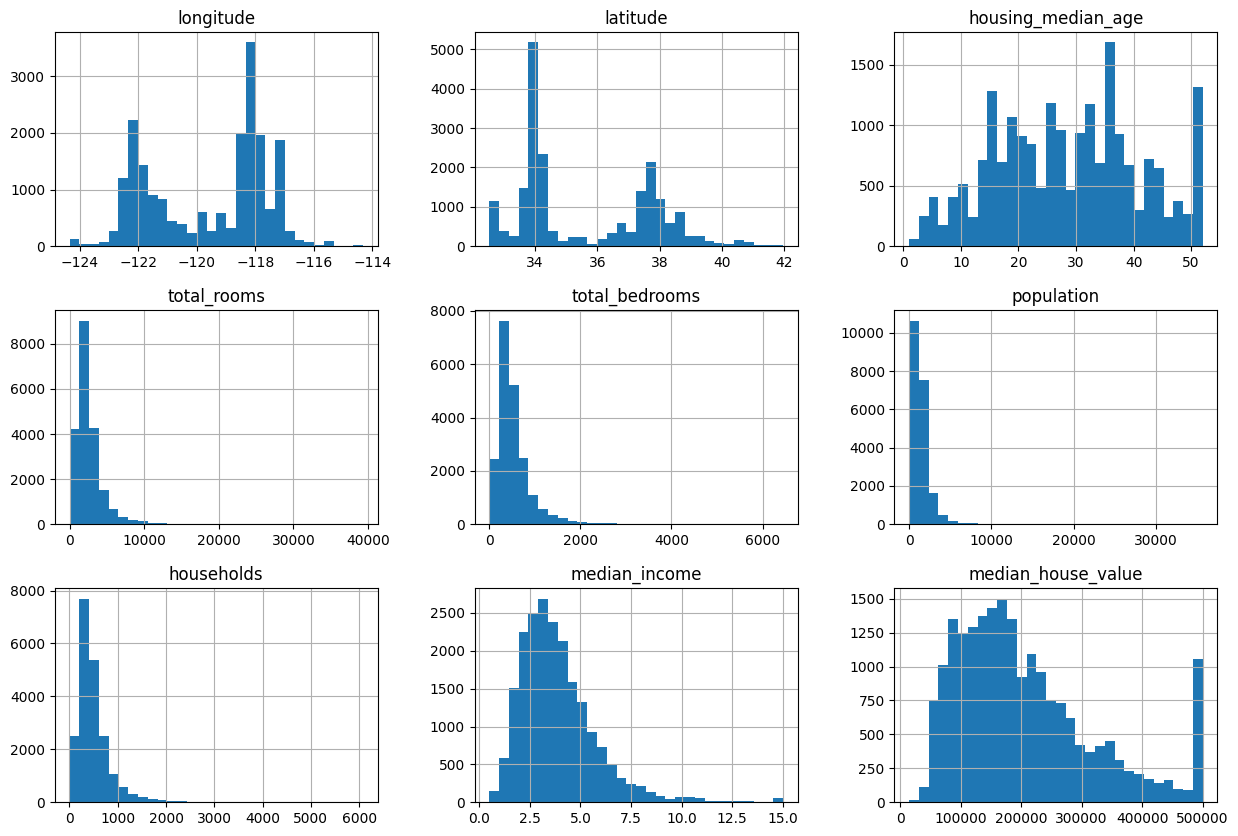

In [ ]:
housing.hist(bins=50, figsize=(20,15))
plt.show()